In [1]:
# IMPORTS
# general
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime
import numpy as np

# for RF
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# for stats
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error
from scipy.stats import pearsonr
from matplotlib.patches import Patch
from statsmodels.tsa.stattools import acf

# global variables
DPI = 200
N_iter = 500

In [10]:
# Load the data: look at street
data_folder = os.path.join('..', 'Data')
file_name = 'Street_NL10236-AQ-METEO.csv' #'Urban_NL10418-AQ-METEO.csv' #'Rural_NL10644-AQ-METEO.csv'
data_imported = pd.read_csv(os.path.join(data_folder, file_name), sep=";")
variable = 'no2' # which variable do we want to predict

# prepare dates
data_imported['date'] = pd.to_datetime(data_imported['date'])

# select only meterological variables + date + look at selected variable 
met_vars_initial = ['wd', 'ws', 't', 'q', 'hourly_rain', 'p', 'n', 'rh']

selected_data = data_imported[met_vars_initial + ['date'] + [variable]]
N_initial = selected_data.shape[0]
selected_data = selected_data.dropna()
N_cleaned = selected_data.shape[0]
selected_data.loc[selected_data[variable] < 0, variable] = 0

print((1 - N_cleaned/N_initial)*100, 'Percent of the data was removed due to missing values')

2.281542322610086 Percent of the data was removed due to missing values


In [66]:
# Renaming columns
new_column_names = {
    'wd': 'Wind Direction',
    'ws': 'Wind Speed',
    't': 'Temperature',
    'q': 'Specific Humidity',
    'hourly_rain': 'Hourly Rainfall',
    'p': 'Pressure',
    'n': 'Cloud Coverage',
    'rh': 'Relative Humidity'
}

selected_data.rename(columns=new_column_names, inplace=True)
met_vars = [new_column_names[var] for var in met_vars_initial]

In [67]:
def prepare_data_for_training(selected_data, vars, variable):
    predictors = selected_data[vars]
    variable_data = selected_data[variable]

    train_mask = selected_data['date'].dt.year <= 2017
    test_mask = selected_data['date'].dt.year > 2017

    X_train, y_train = predictors[train_mask], variable_data[train_mask]
    X_test, y_test = predictors[test_mask], variable_data[test_mask]

    t_train = selected_data['date'][train_mask]
    t_test = selected_data['date'][test_mask]

    return X_train, y_train, t_train, X_test, y_test, t_test

X_train, y_train, t_train, X_test, y_test, t_test = prepare_data_for_training(selected_data, met_vars, variable)

Text(0, 0.5, '[$\\text{NO}_2$] ($\\mu g/\\text{m}^3$)')

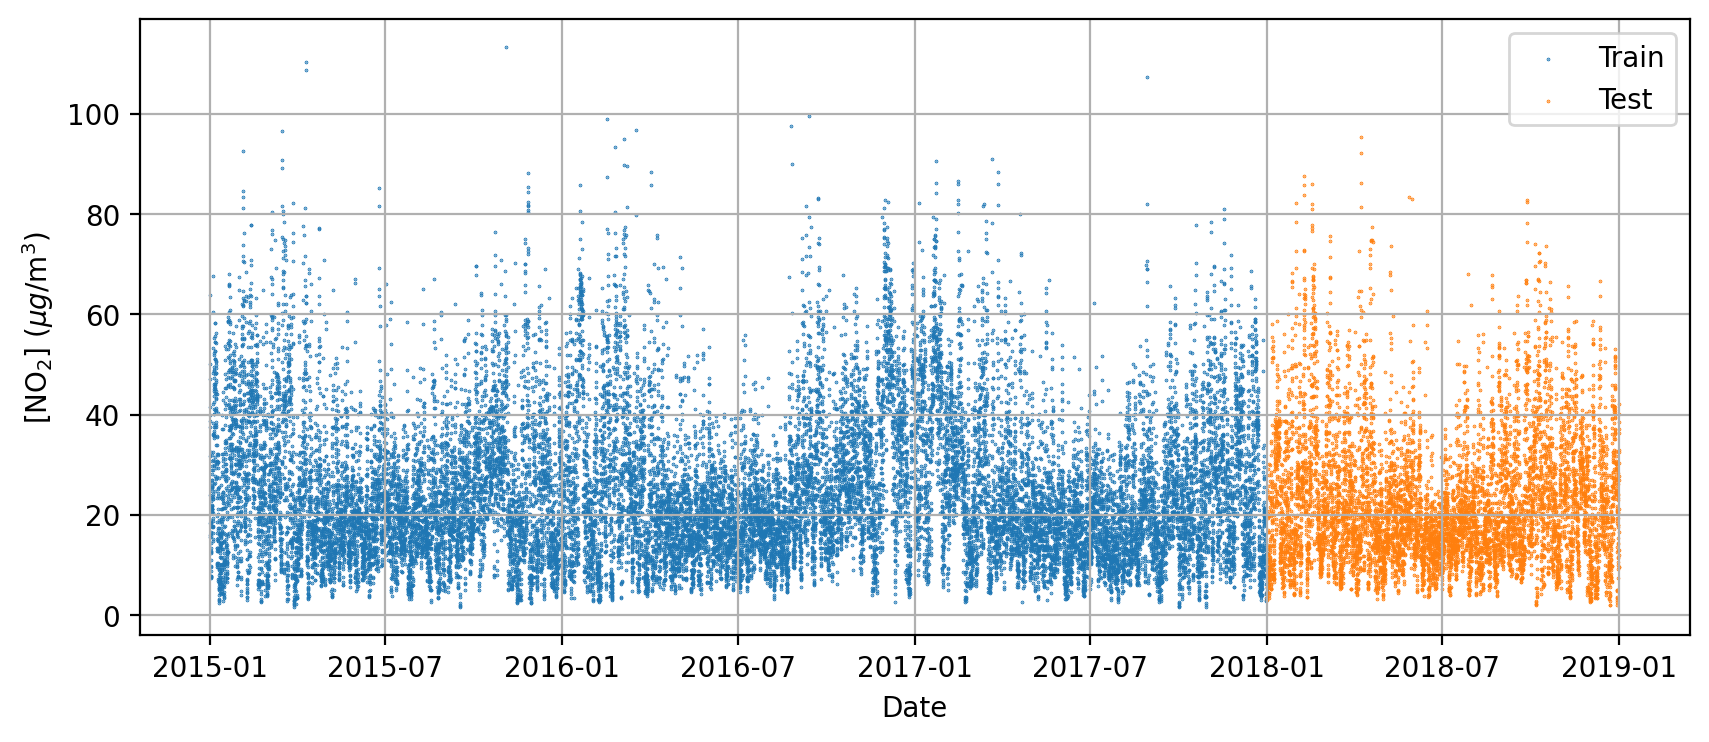

In [68]:
plt.figure(dpi=DPI, figsize=(10, 4))
plt.scatter(t_train, y_train, label='Train', s=0.1)
plt.scatter(t_test, y_test, label='Test', s=0.1)
plt.grid()
plt.legend()
plt.xlabel('Date')
plt.ylabel(r'[$\text{NO}_2$] ($\mu g/\text{m}^3$)')

In [69]:
def RF_optimization(X_train, y_train, n_iter=20, random_state=None):
    # Define the hyperparameter grid
    param_dist = {
        'n_estimators': randint(20, 200),
        'min_samples_leaf': randint(3, 10),
        'max_samples': uniform(0, 0.9),    
        'max_features': uniform(0, 1),
        'max_depth': randint(2, 20),
    }

    # Create the RandomForestRegressor
    rf_model = RandomForestRegressor(random_state=random_state)

    # Create the RandomizedSearchCV instance
    random_search = RandomizedSearchCV(
        estimator=rf_model,
        param_distributions=param_dist,
        n_iter=n_iter,  # Number of random combinations to try
        cv=5,       # Number of cross-validation folds --> no separate validation data needed
        n_jobs=-1,  # Use all available CPU cores
        random_state=random_state
    )

    # Fit the RandomizedSearchCV instance to your data
    random_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = random_search.best_params_
    print("Best Hyperparameters:")
    print(best_params)

    # Get the best model
    best_rf_model = random_search.best_estimator_

    return best_rf_model, best_params


In [70]:
best_rf_model, best_params = RF_optimization(X_train, y_train, n_iter=N_iter)

# Make predictions with the best model
y_train_pred = best_rf_model.predict(X_train)
y_test_pred = best_rf_model.predict(X_test)

Best Hyperparameters:
{'max_depth': 18, 'max_features': 0.39390173641499515, 'max_samples': 0.25980542252068095, 'min_samples_leaf': 6, 'n_estimators': 172}


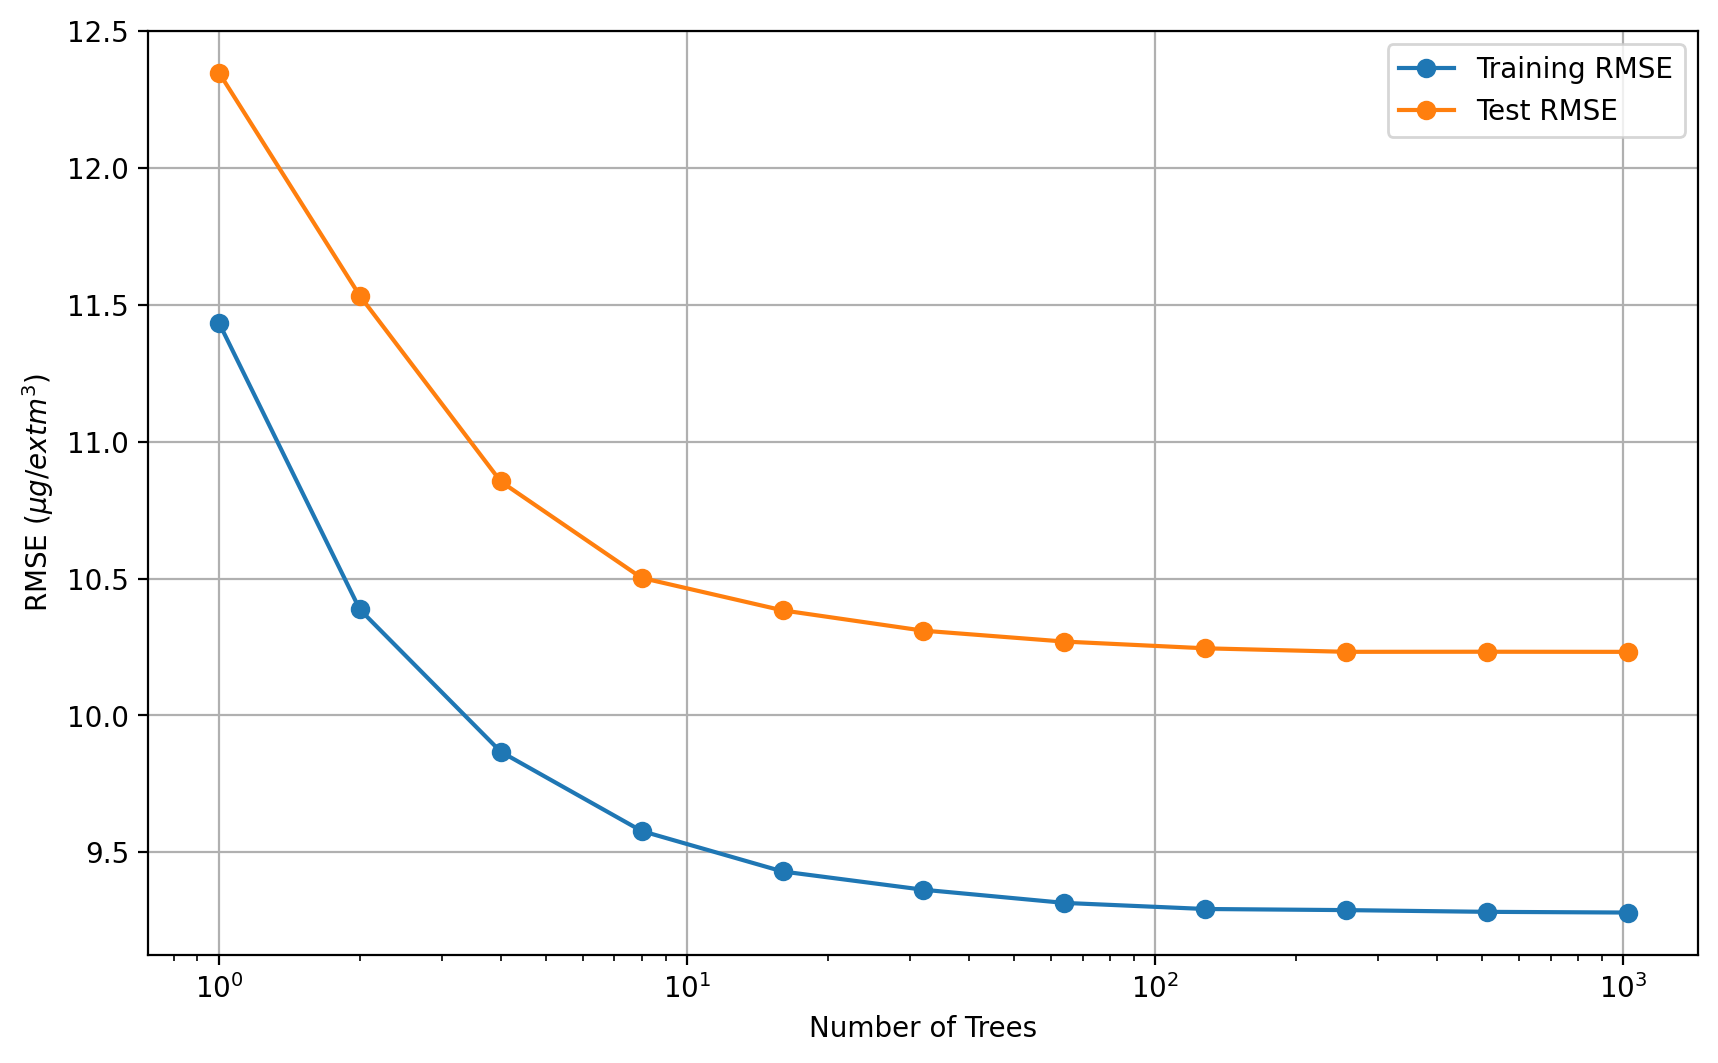

In [71]:
def check_tree_number(params, N_tree=11, n_runs=1, plot=True, random_state=None):
    n_tree_test_arr = [2**n for n in range(N_tree)]
    train_rmse_list = []
    test_rmse_list = []

    for n_trees_test in n_tree_test_arr:
        train_rmse_accumulator = 0
        test_rmse_accumulator = 0

        for _ in range(n_runs):
            test_params = params.copy()
            test_params['n_estimators'] = n_trees_test
            
            # Train a model using the test_params
            rf_test_model = RandomForestRegressor(**test_params, random_state=random_state)
            rf_test_model.fit(X_train, y_train)
            
            # Make predictions
            y_train_pred = rf_test_model.predict(X_train)
            y_test_pred = rf_test_model.predict(X_test)
            
            # Calculate RMSE
            train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
            
            # Accumulate RMSE for averaging
            train_rmse_accumulator += train_rmse
            test_rmse_accumulator += test_rmse
        
        # Calculate the average RMSE and append it to the results list
        train_rmse_list.append(train_rmse_accumulator / n_runs)
        test_rmse_list.append(test_rmse_accumulator / n_runs)

    if plot:
        plt.figure(figsize=(10, 6), dpi=DPI)
        plt.plot(n_tree_test_arr, train_rmse_list, label='Training RMSE', marker='o')
        plt.plot(n_tree_test_arr, test_rmse_list, label='Test RMSE', marker='o')
        plt.xscale('log')  # because n_trees_test are powers of 2
        plt.xlabel('Number of Trees')
        plt.ylabel('RMSE ($\mu g/\text{m}^3$)')
        plt.legend()
        plt.grid(True)
        plt.show()

    return n_tree_test_arr, train_rmse_list, test_rmse_list

if True:
    check_tree_number(best_params, N_tree=11, n_runs=10);

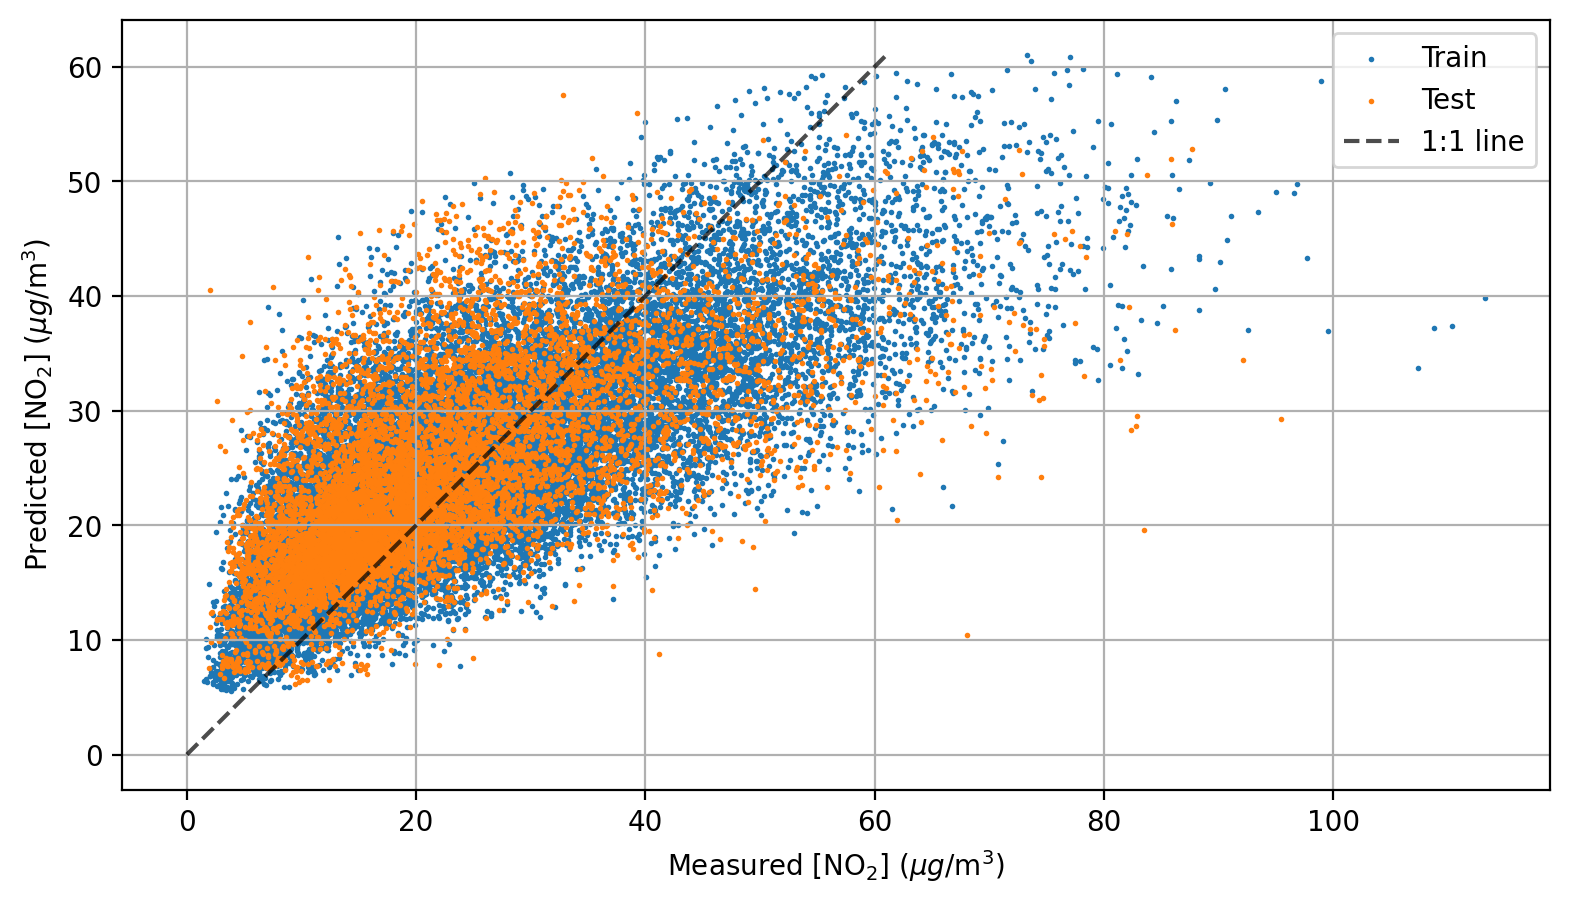

In [103]:
def plot_model_pred(y_train, y_train_pred, y_test, y_test_pred):
    fig, ax1 = plt.subplots(1, 1, dpi=DPI, figsize=(10, 5))
    
    # Scatter plots
    size = 1
    transp = 1
    ax1.scatter(y_train, y_train_pred, label='Train', color='tab:blue', s=size, alpha=transp)
    ax1.scatter(y_test, y_test_pred, label='Test', color='tab:orange', s=size, alpha=transp)

    # 1:1 line
    line = np.array([0, np.max([np.max(y_train_pred), np.max(y_test_pred)])])
    ax1.plot(line, line, zorder=5, linestyle='dashed', color='black', label='1:1 line', alpha=.7)
    ax1.set_aspect('equal', 'box')

    ax1.set_xlabel(r'Measured [$\text{NO}_2$] ($\mu g/\text{m}^3$)')
    ax1.set_ylabel(r'Predicted [$\text{NO}_2$] ($\mu g/\text{m}^3$)')
    ax1.legend()
    ax1.grid()
    
    plt.show()
plot_model_pred(y_train, y_train_pred, y_test, y_test_pred)

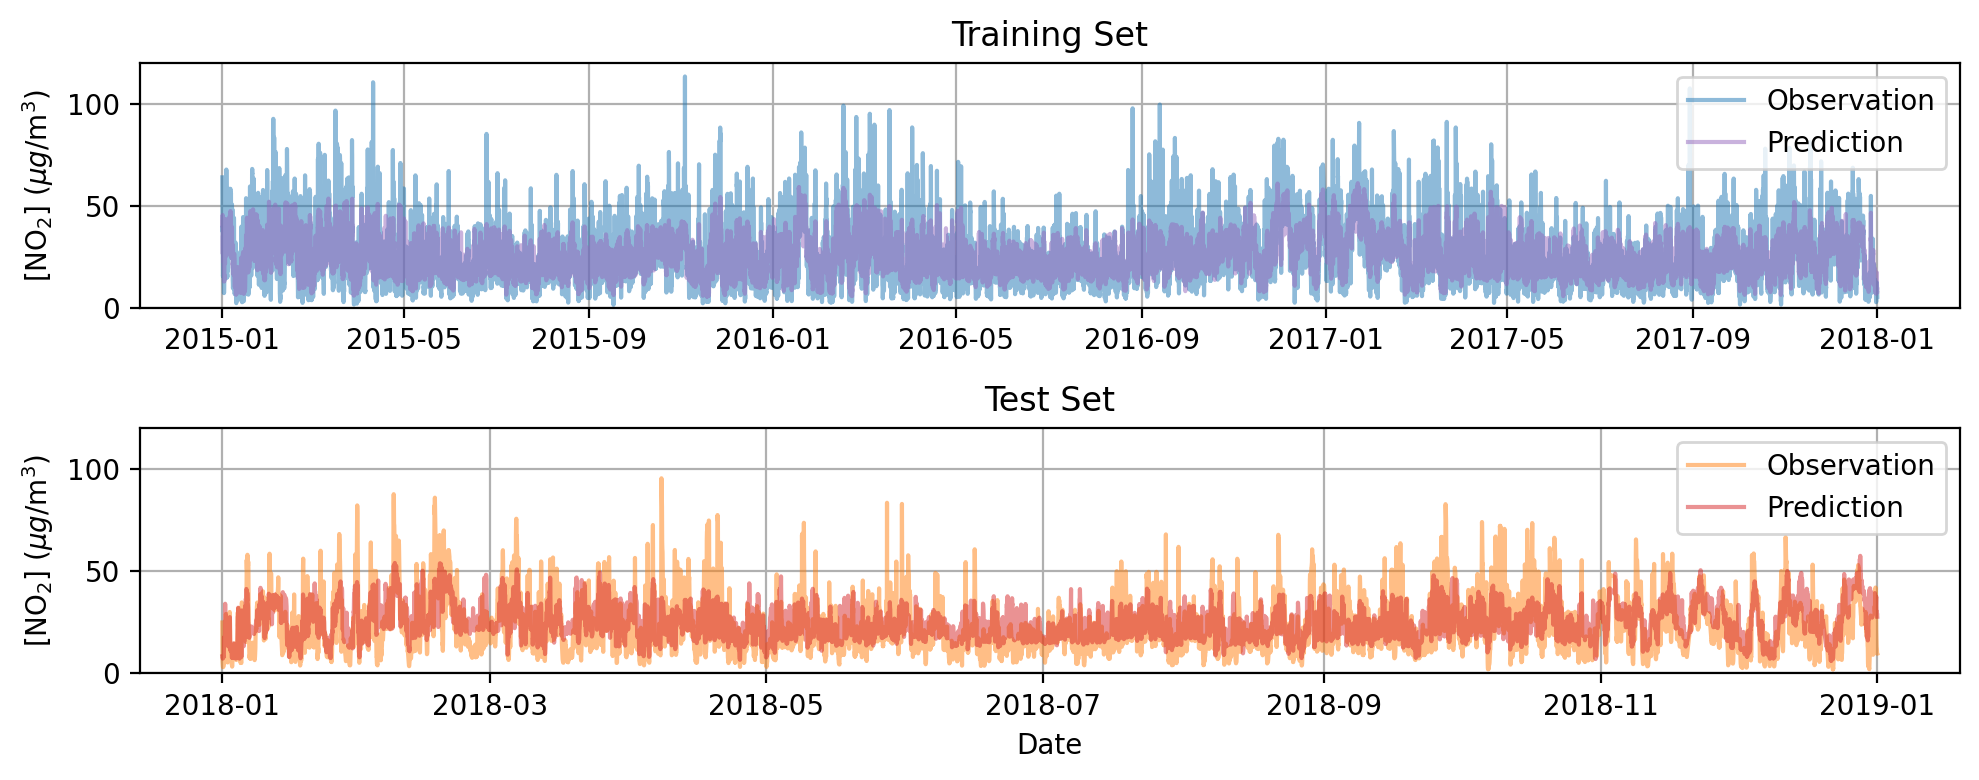

In [73]:
# Your function
def plot_model_pred_timeseries(t_train, y_train, y_train_pred, t_test, y_test, y_test_pred, all=True, start_month=1, n_months=3, start_day=1, n_days=3, residuals=False):
    if not residuals:
        fig, (ax1, ax2) = plt.subplots(2, 1, dpi=DPI, figsize=(10, 4), sharey=True)
    else:
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, dpi=DPI, figsize=(10, 10))

    ax1.plot(t_train, y_train, alpha=.5, label='Observation', color='tab:blue')
    ax1.plot(t_train, y_train_pred, alpha=.5, label='Prediction', color="tab:purple")
    ax1.set_ylim(0, 120)
    ax1.legend(loc='upper right')
    ax1.grid(True)
    ax1.set_ylabel(r'[$\text{NO}_2$] ($\mu g/\text{m}^3$)')
    ax1.set_title('Training Set')

    ax2.plot(t_test, y_test, alpha=.5, label='Observation', color='tab:orange')
    ax2.plot(t_test, y_test_pred, alpha=.5, label='Prediction', color="tab:red")
    ax2.grid(True)
    ax2.set_xlabel('Date')
    ax2.set_ylabel(r'[$\text{NO}_2$] ($\mu g/\text{m}^3$)')
    ax2.legend(loc='upper right')
    ax2.set_title('Test Set')

    if not all:
        ax1.set_xlim(datetime.date(2017, start_month, start_day), datetime.date(2017, start_month + n_months, start_day + n_days))
        ax2.set_xlim(datetime.date(2018, start_month, start_day), datetime.date(2018, start_month + n_months, start_day + n_days))

    if residuals:
        # Calculate residuals
        train_residuals = y_train - y_train_pred
        test_residuals = y_test - y_test_pred

        # Residuals plot
        ax3.plot(t_train, train_residuals, alpha=.5, label='Train Residuals')
        ax3.plot(t_test, test_residuals, alpha=.5, label='Test Residuals')
        ax3.grid(True)
        ax3.legend()
        ax3.set_ylabel(r'Residuals ($\mu g/\text{m}^3$)')

        # Calculate and plot ACF, then perform Fourier analysis
        autocorr = acf(train_residuals, nlags=24*365, fft=True) # ACF calculation
        spectrum = np.fft.fft(autocorr)  # FFT of ACF
        freq = np.fft.fftfreq(len(spectrum)) 

        # ACF plot of residuals
        x = np.arange(len(autocorr)) / 24 # Convert lag to days
        ax4.plot(x, autocorr)
        ax4.set_xlabel('Lag [days]')
        ax4.set_ylabel('Autocorrelation')
        ax4.grid(True)
        ax4.set_yscale('log')
        ax4.set_ylim(1e-3, 1)

        # For visualization, usually just half of the spectrum is enough
        pos_mask = np.where(freq > 0)
        freqs = freq[pos_mask]
        periods = 1 / freqs # Convert frequency to period in days
        power = np.abs(spectrum[pos_mask])**2
        power_normalized = power / np.sum(power)

        ax5.loglog(periods, power_normalized)  # Plot the power spectrum of ACF
        ax5.set_xlabel('Period [days]')
        ax5.set_ylabel('Power')
        ax5.grid(True)

    plt.tight_layout()
    plt.show()


plot_model_pred_timeseries(t_train, y_train, y_train_pred, t_test, y_test, y_test_pred, all=True)


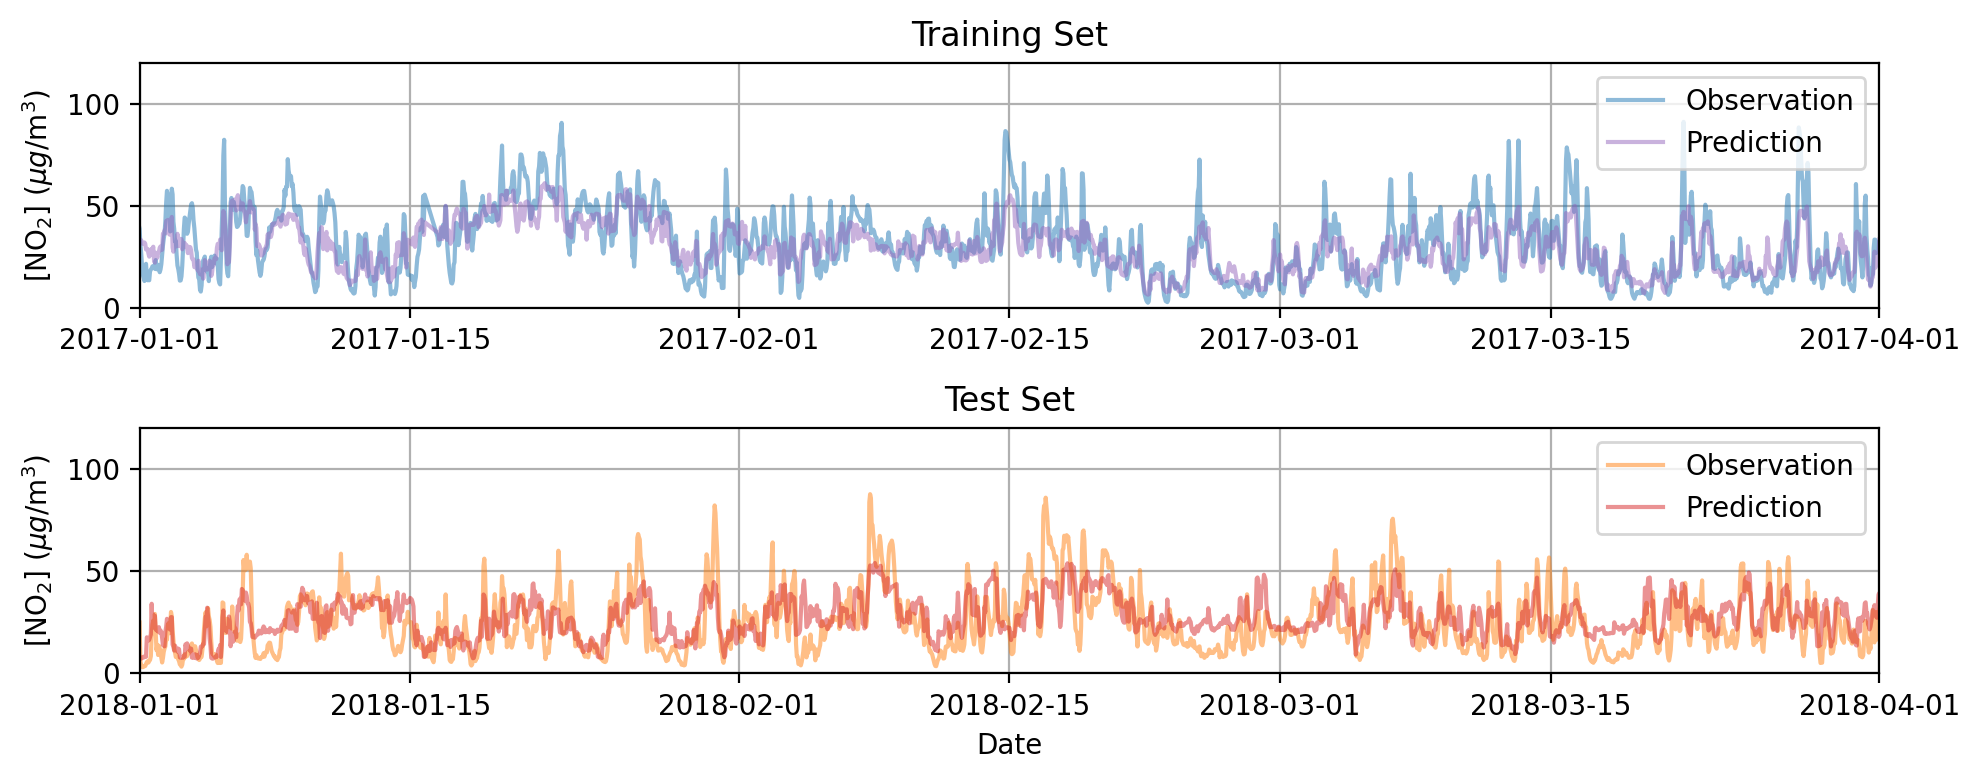

In [74]:
plot_model_pred_timeseries(t_train, y_train, y_train_pred, t_test, y_test, y_test_pred, all=False, start_month=1, n_months=3, start_day=1, n_days=0)

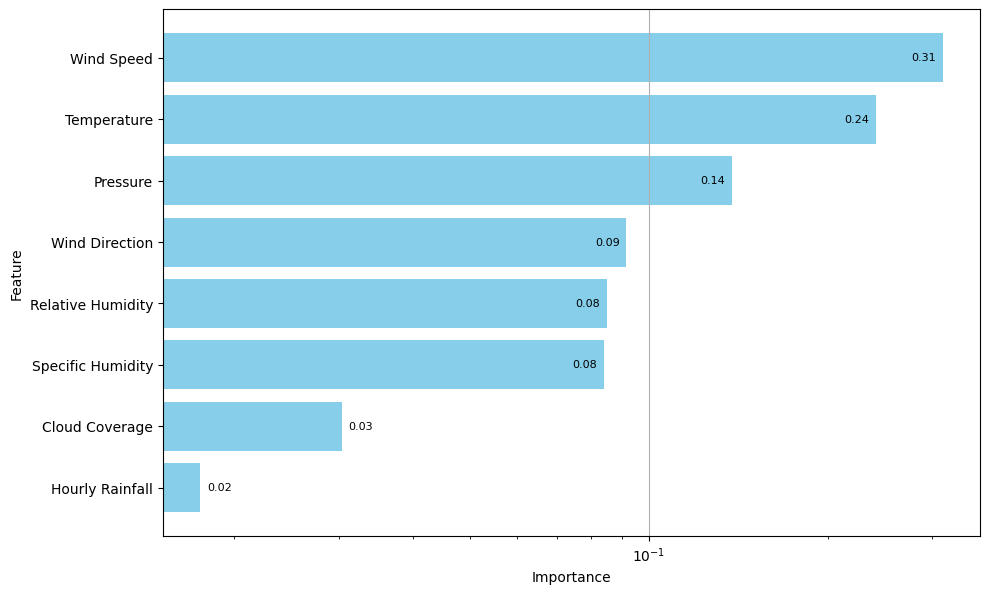

,Feature,Importance
1,Wind Speed,0.312643
2,Temperature,0.241074
5,Pressure,0.137746
0,Wind Direction,0.091630
7,Relative Humidity,0.084960
3,Specific Humidity,0.084063
6,Cloud Coverage,0.030366
4,Hourly Rainfall,0.017517


In [75]:
def get_RF_feature_imp(model, X_train, plot=False, use_permutation=False, target=None, random_state=None, decimals=2, relative_threshold = 0.1):
    '''Calculates feature importance using Gini importance or permutation importance.
    
    Args:
        model (object): The trained Random Forest model.
        X_train (DataFrame): The training data features.
        plot (bool, optional): Whether to plot the feature importances. Default is False.
        use_permutation (bool, optional): If True, calculate permutation importance. 
            If False (default), calculate Gini importance.
        random_state (int or None, optional): Random seed for permutation importance. Default is None.
    
    Returns:
        DataFrame: A DataFrame containing feature importances.
    '''
    if use_permutation:
        result = permutation_importance(model, X_train, target, random_state=random_state)
        importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': result.importances_mean})
    else:
        feature_importances = model.feature_importances_
        importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

    importances_df = importances_df.sort_values(by='Importance', ascending=False)

    if plot:
        plt.figure(figsize=(10, 6))  # Set figure size
        bars = plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
        plt.grid(axis='x')  # Add a grid along the x-axis
        plt.tight_layout()  # Adjust layout to prevent clipping of labels
        plt.xscale('log')
        
        # Annotating the bars
        thresh = relative_threshold * importances_df.max().iloc[1]
        for bar in bars:
            # If bar width is smaller than a threshold, adjust text position and alignment
            if bar.get_width() < thresh:  # example threshold
                plt.annotate(f"{bar.get_width():.{decimals}f}",
                            xy=(bar.get_width(), bar.get_y() + bar.get_height()/2),
                            xytext=(5, 0),  # adjust the position of text to avoid overlap with bars
                            textcoords="offset points",
                            ha='left', va='center',
                            fontsize=8, color='black')
            else:
                plt.annotate(f"{bar.get_width():.{decimals}f}",
                            xy=(bar.get_width(), bar.get_y() + bar.get_height()/2),
                            xytext=(-5, 0),  # adjust the position of text to avoid overlap with bars
                            textcoords="offset points",
                            ha='right', va='center',
                            fontsize=8, color='black')
            
        plt.show()

    return importances_df

        
get_RF_feature_imp(best_rf_model, X_train, plot=True, use_permutation=False, decimals=2)

In [98]:
def get_RF_stats(y_train, y_test, y_train_pred, y_test_pred):
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    correlation_train, _ = pearsonr(y_train, y_train_pred)
    correlation_test, _ = pearsonr(y_test, y_test_pred)

    explained_variance_train = explained_variance_score(y_train, y_train_pred)
    explained_variance_test = explained_variance_score(y_test, y_test_pred)

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    results = {
        'RMSE Train': rmse_train,
        'RMSE Test': rmse_test,
        'Correlation Train': correlation_train,
        'Correlation Test': correlation_test,
        'Explained Variance Train': explained_variance_train,
        'Explained Variance Test': explained_variance_test,
        'MAE Train': mae_train,
        'MAE Test': mae_test
    }

    latex_table = "\\begin{tabular}{lcc}\n\\toprule\n"
    latex_table += "Metric & Train & Test \\\\ \\midrule\n"

    metrics_train = [key for key in results.keys() if "Train" in key]
    metrics_test = [key.replace("Train", "Test") for key in metrics_train]

    for m_train, m_test in zip(metrics_train, metrics_test):
        unit = " ($\\mu g/m^3$)" if "RMSE" in m_train or "MAE" in m_train else ""
        latex_table += f"{m_train.replace(' Train', '')}{unit} & {results[m_train]:.2f} & {results[m_test]:.2f} \\\\ \n"

    latex_table += "\\bottomrule\n\\end{tabular}"
    
    print(latex_table)

    return results


RF_stats_1 = get_RF_stats(y_train, y_test, y_train_pred, y_test_pred);

\begin{tabular}{lcc}
\toprule
Metric & Train & Test \\ \midrule
RMSE ($\mu g/m^3$) & 9.28 & 10.23 \\ 
Correlation & 0.77 & 0.64 \\ 
Explained Variance & 0.58 & 0.41 \\ 
MAE ($\mu g/m^3$) & 6.93 & 7.84 \\ 
\bottomrule
\end{tabular}


# Improved RF 1

In [77]:
# add extra explainers
selected_data_2 = data_imported[met_vars_initial + ['date'] + [variable]].dropna()
selected_data_2.rename(columns=new_column_names, inplace=True)
selected_data_2.loc[selected_data_2[variable] < 0, variable] = 0

In [78]:
def is_winter_time(row):
    year = row['date'].year
    # DST starts on the last Sunday of March
    dst_start = max([day for day in pd.date_range(f"{year}-03-01", f"{year}-03-31") if day.weekday() == 6])
    # DST ends on the last Sunday of October
    dst_end = max([day for day in pd.date_range(f"{year}-10-01", f"{year}-10-31") if day.weekday() == 6])
    # Return 1 if date is outside DST period, 0 otherwise
    return 1 if row['date'] < dst_start or row['date'] > dst_end else 0

In [79]:

def get_extra_explainers(data):
    # add more variables that could explain emissions
    dutch_holidays = [
        datetime.date(datetime.MINYEAR, 1, 1),   # New Year's Day
        datetime.date(datetime.MINYEAR, 4, 27),  # King's Day
        datetime.date(datetime.MINYEAR, 5, 5),   # Liberation Day
        datetime.date(datetime.MINYEAR, 5, 25),  # Ascension Day
        datetime.date(datetime.MINYEAR, 6, 5),   # Whit Monday
        datetime.date(datetime.MINYEAR, 12, 25), # Christmas Day
        datetime.date(datetime.MINYEAR, 12, 26), # Boxing Day
    ]

    data['Hour of Day'] = data['date'].dt.hour
    data['Day of Year'] = data['date'].dt.dayofyear
    data['Day of Week'] = data['date'].dt.dayofweek
    data['day_of_month'] = data['date'].dt.day 
    data['week_of_year'] = data['date'].dt.isocalendar().week

    data['month_day'] = data['date'].dt.strftime('%m-%d')
    data['holiday'] = data['month_day'].isin(date.strftime('%m-%d') for date in dutch_holidays).astype(int)
    data.drop(columns=['month_day'], inplace=True)
    data['holiday']

    data['Winter Time'] = data.apply(is_winter_time, axis=1)
    data['working_day'] = ((data['Day of Week'] >= 0) & (data['Day of Week'] <= 4)).astype(int)
    return data

extra_explainers = ['Hour of Day', 'Day of Year', 'Day of Week']#, 'working_day', 'week_of_year', 'holiday', 'day_of_month', 'Winter Time]
get_extra_explainers(selected_data_2);

In [80]:
X_train_2, y_train_2, t_train_2, X_test_2, y_test_2, t_test_2 = prepare_data_for_training(selected_data_2, met_vars + extra_explainers, variable)

In [81]:
best_rf_model_2, best_params_2 = RF_optimization(X_train_2, y_train_2, n_iter=N_iter)

# Make predictions with the best model
y_train_pred_2 = best_rf_model_2.predict(X_train_2)
y_test_pred_2 = best_rf_model_2.predict(X_test_2)

Best Hyperparameters:
{'max_depth': 18, 'max_features': 0.5339315309412109, 'max_samples': 0.7410919427651108, 'min_samples_leaf': 4, 'n_estimators': 195}


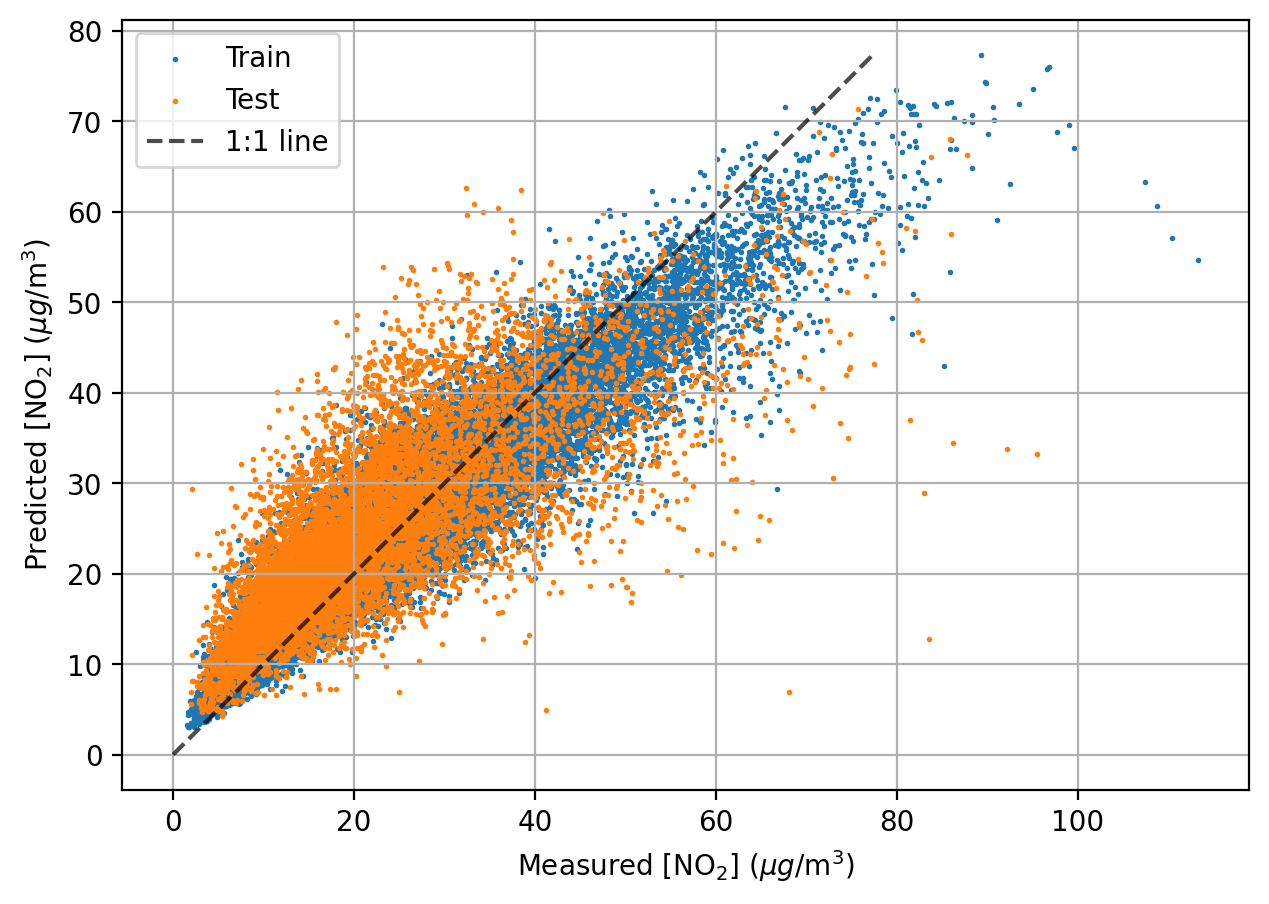

In [104]:
plot_model_pred(y_train_2, y_train_pred_2, y_test_2, y_test_pred_2)

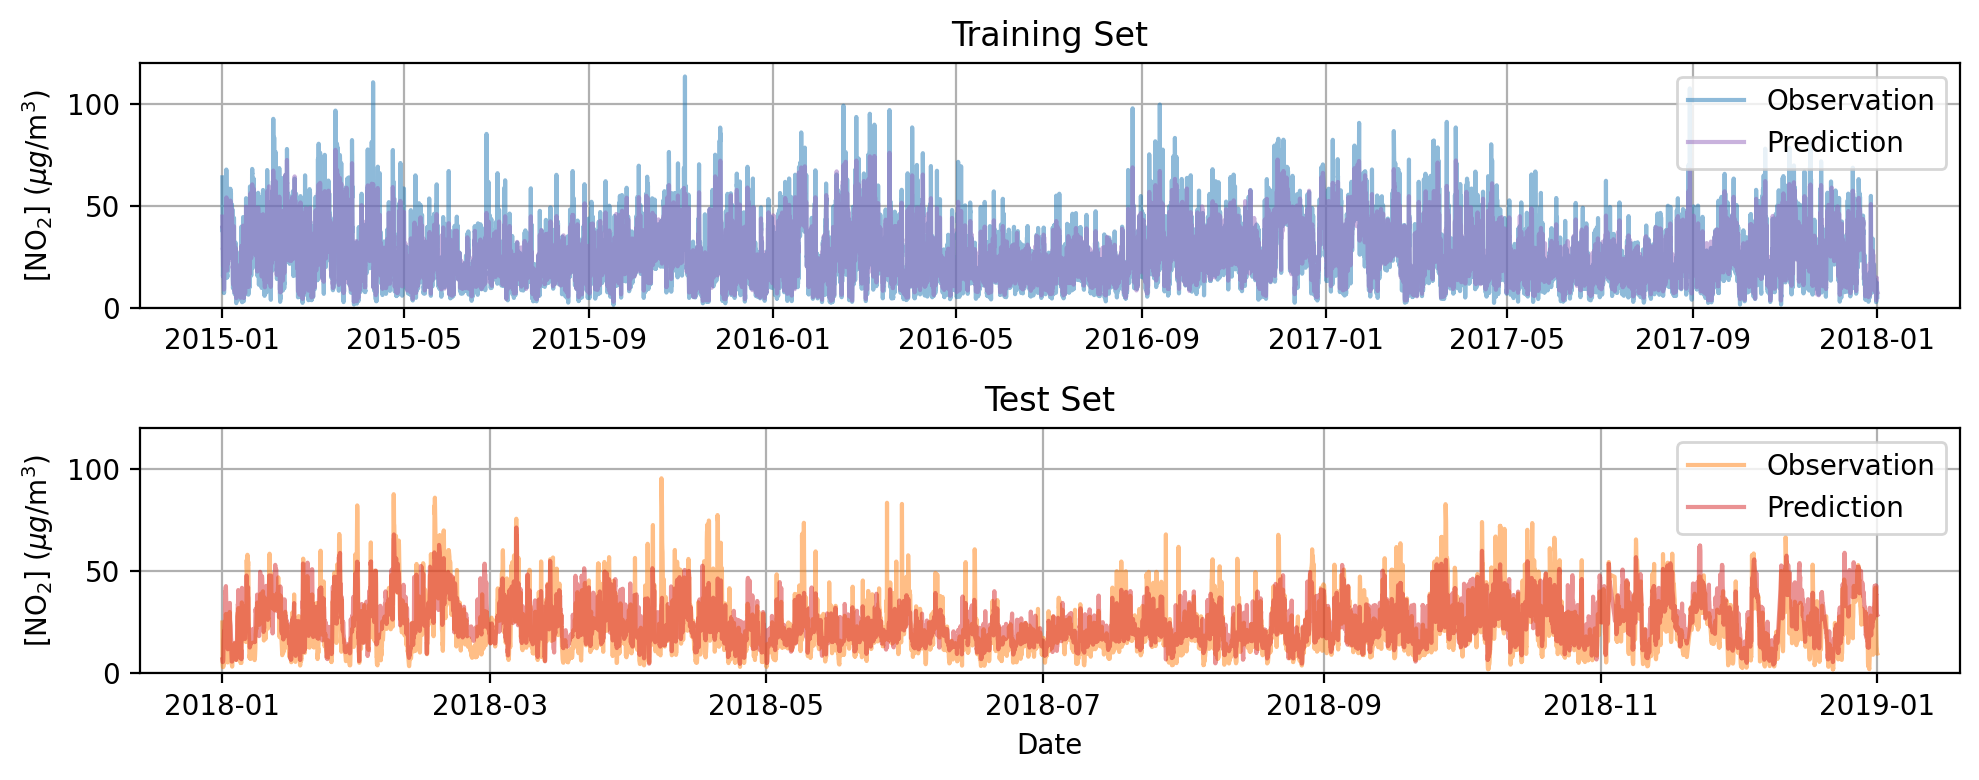

In [83]:
plot_model_pred_timeseries(t_train_2, y_train_2, y_train_pred_2, t_test_2, y_test_2, y_test_pred_2, all=True)

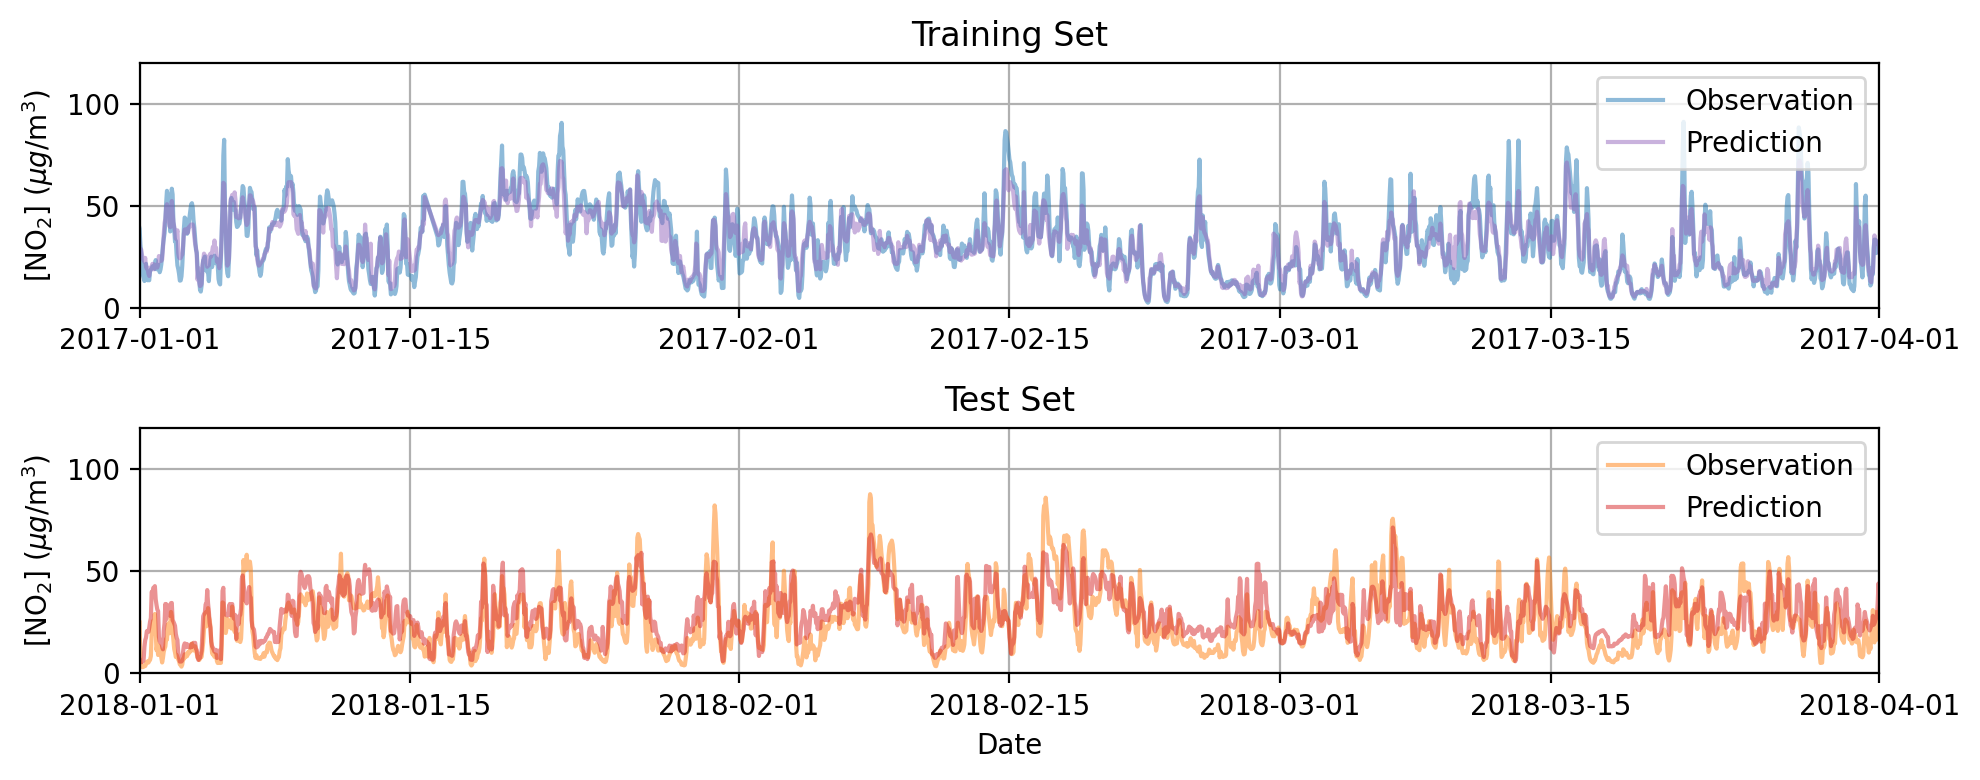

In [84]:
plot_model_pred_timeseries(t_train_2, y_train_2, y_train_pred_2, t_test_2, y_test_2, y_test_pred_2, all=False, start_month=1, n_months=3, start_day=1, n_days=0)

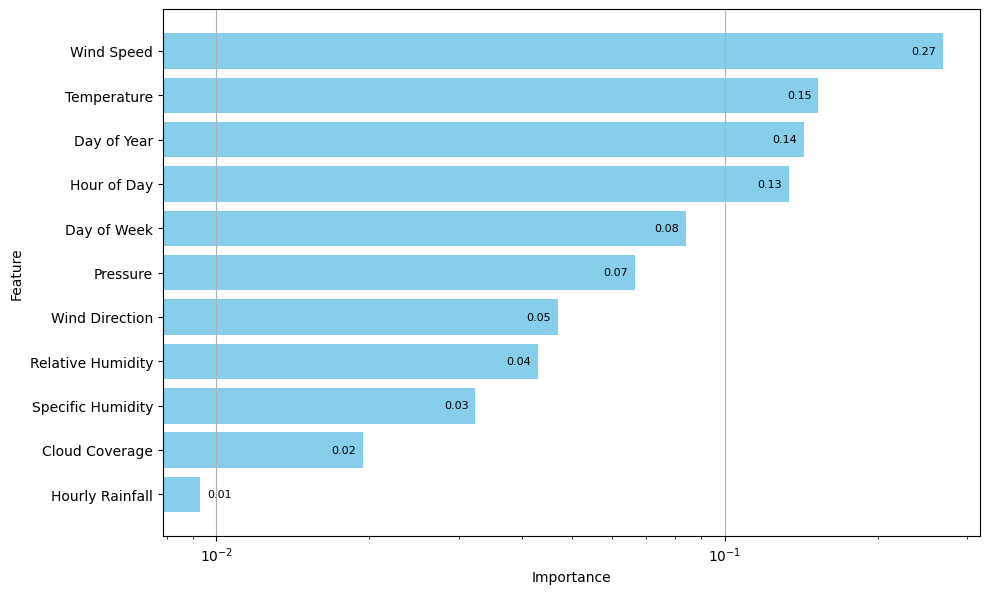

              Feature  Importance
1          Wind Speed    0.268522
2         Temperature    0.152881
9         Day of Year    0.143387
8         Hour of Day    0.133950
10        Day of Week    0.083818
5            Pressure    0.066632
0      Wind Direction    0.046896
7   Relative Humidity    0.042876
3   Specific Humidity    0.032318
6      Cloud Coverage    0.019438
4     Hourly Rainfall    0.009283


In [85]:
print(get_RF_feature_imp(best_rf_model_2, X_train_2, plot=True, decimals=2, relative_threshold=0.05))

In [86]:
RF_stats_2 = get_RF_stats(y_train_2, y_test_2, y_train_pred_2, y_test_pred_2)

\begin{tabular}{lcc}
\toprule
Metric & Train & Test \\ \midrule
RMSE ($\mu g/m^3$) & 4.9769 & 8.7821 \\ 
Correlation & 0.9446 & 0.7630 \\ 
Explained Variance & 0.8800 & 0.5807 \\ 
MAE ($\mu g/m^3$) & 3.5512 & 6.6602 \\ 
\bottomrule
\end{tabular}


In [99]:
def compare_rf_stats_relative(RF_stats_1, RF_stats_2):
    stat_names = [
    'RMSE Train',
    'RMSE Test',
    'Correlation Train',
    'Correlation Test',
    'Explained Variance Train',
    'Explained Variance Test',
    'MAE Train',
    'MAE Test'
    ]
    
    RF1_stats = np.array([RF_stats_1[name] for name in stat_names])
    RF2_stats = np.array([RF_stats_2[name] for name in stat_names])
    
    # Calculating the relative differences
    relative_differences = ((RF2_stats - RF1_stats) / RF1_stats) * 100 
    
    # Stripping " Train" and " Test" from labels for x-axis
    labels = [name.replace(" Train", "").replace(" Test", "") for name in stat_names]

    # Get unique labels
    unique_labels = []
    [unique_labels.append(label) for label in labels if label not in unique_labels]
    
    x = np.arange(len(unique_labels))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.grid(True)

    # Differentiating between train and test stats by color
    train_color = 'tab:blue'
    test_color = 'tab:orange'
    colors = [train_color if 'Train' in name else test_color for name in stat_names]

    # Plotting Train and Test bars side by side
    for i, (label, diff, color) in enumerate(zip(labels, relative_differences, colors)):
        bar = ax.bar(x[i//2] + (i%2) * width, diff, width, color=color)
        
        # Adding percentage above the bars
        height = bar[0].get_height()
        ax.annotate(f'{diff:.1f}%',
                    xy=(bar[0].get_x() + bar[0].get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    # Adding a zero line
    ax.axhline(0, color='black', linewidth=0.8)
    
    ax.set_xlabel('Metric')
    ax.set_ylabel('Relative Difference (%)')
    ax.set_xticks(x + width/2)  # position x-axis labels in the center of grouped bars
    ax.set_xticklabels(unique_labels)
    
    # Creating a custom legend
    legend_elements = [Patch(facecolor=train_color, label='Train'),
                       Patch(facecolor=test_color, label='Test')]
    ax.legend(handles=legend_elements)

    fig.tight_layout()
    plt.show()


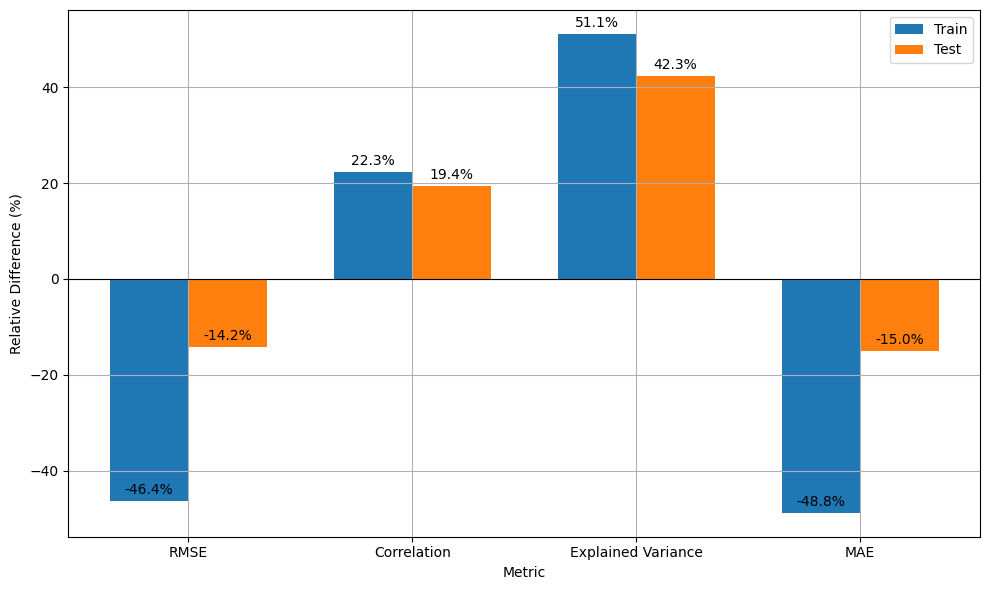

In [100]:
compare_rf_stats_relative(RF_stats_1, RF_stats_2)

# Improved RF 2

In [91]:
# add extra components
comp_vars = ['o3', 'ox']
selected_data_3 = data_imported[met_vars_initial + comp_vars + ['date'] + [variable]].dropna()
selected_data_3.rename(columns=new_column_names, inplace=True)
selected_data_3.loc[selected_data_3[variable] < 0, variable] = 0
get_extra_explainers(selected_data_3)
X_train_3, y_train_3, t_train_3, X_test_3, y_test_3, t_test_3 = prepare_data_for_training(selected_data_3, met_vars + comp_vars + extra_explainers, variable)

In [92]:
best_rf_model_3, best_params_3 = RF_optimization(X_train_3, y_train_3, n_iter=N_iter)

# Make predictions with the best model
y_train_pred_3 = best_rf_model_3.predict(X_train_3)
y_test_pred_3 = best_rf_model_3.predict(X_test_3)

Best Hyperparameters:
{'max_depth': 17, 'max_features': 0.967619018508668, 'max_samples': 0.6495621430311089, 'min_samples_leaf': 3, 'n_estimators': 59}


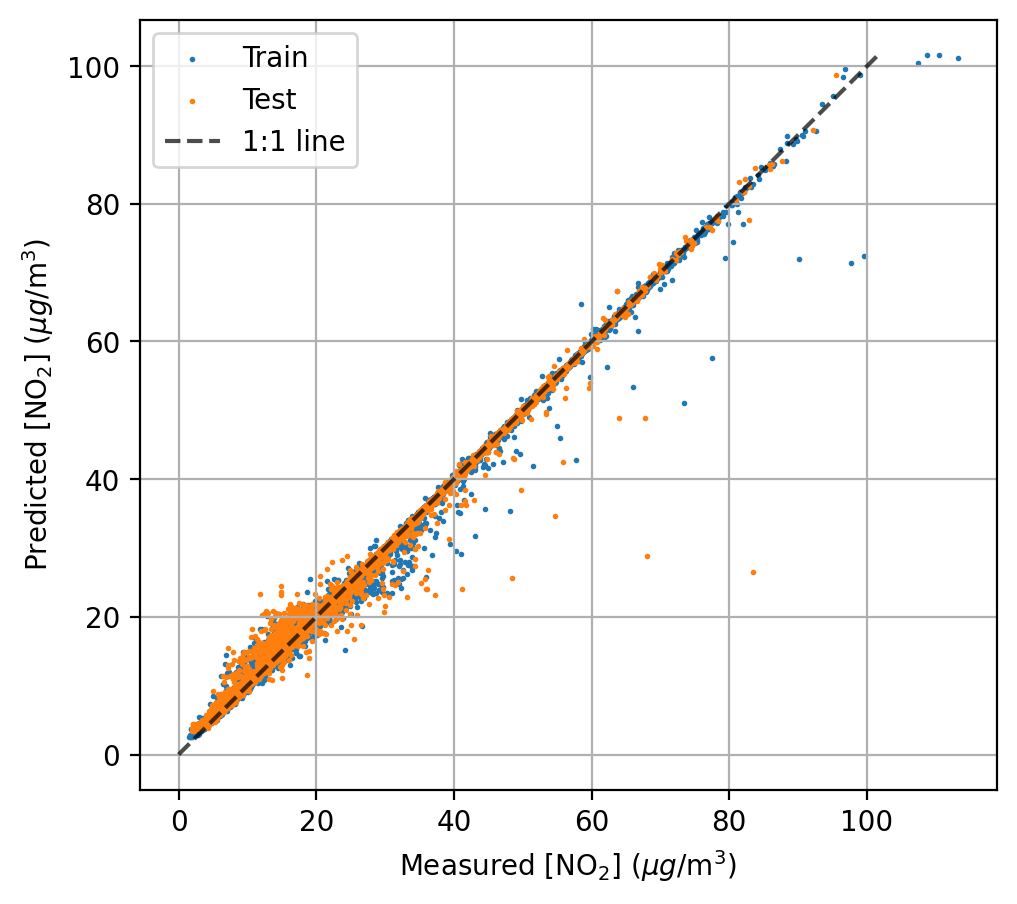

In [105]:
plot_model_pred(y_train_3, y_train_pred_3, y_test_3, y_test_pred_3)

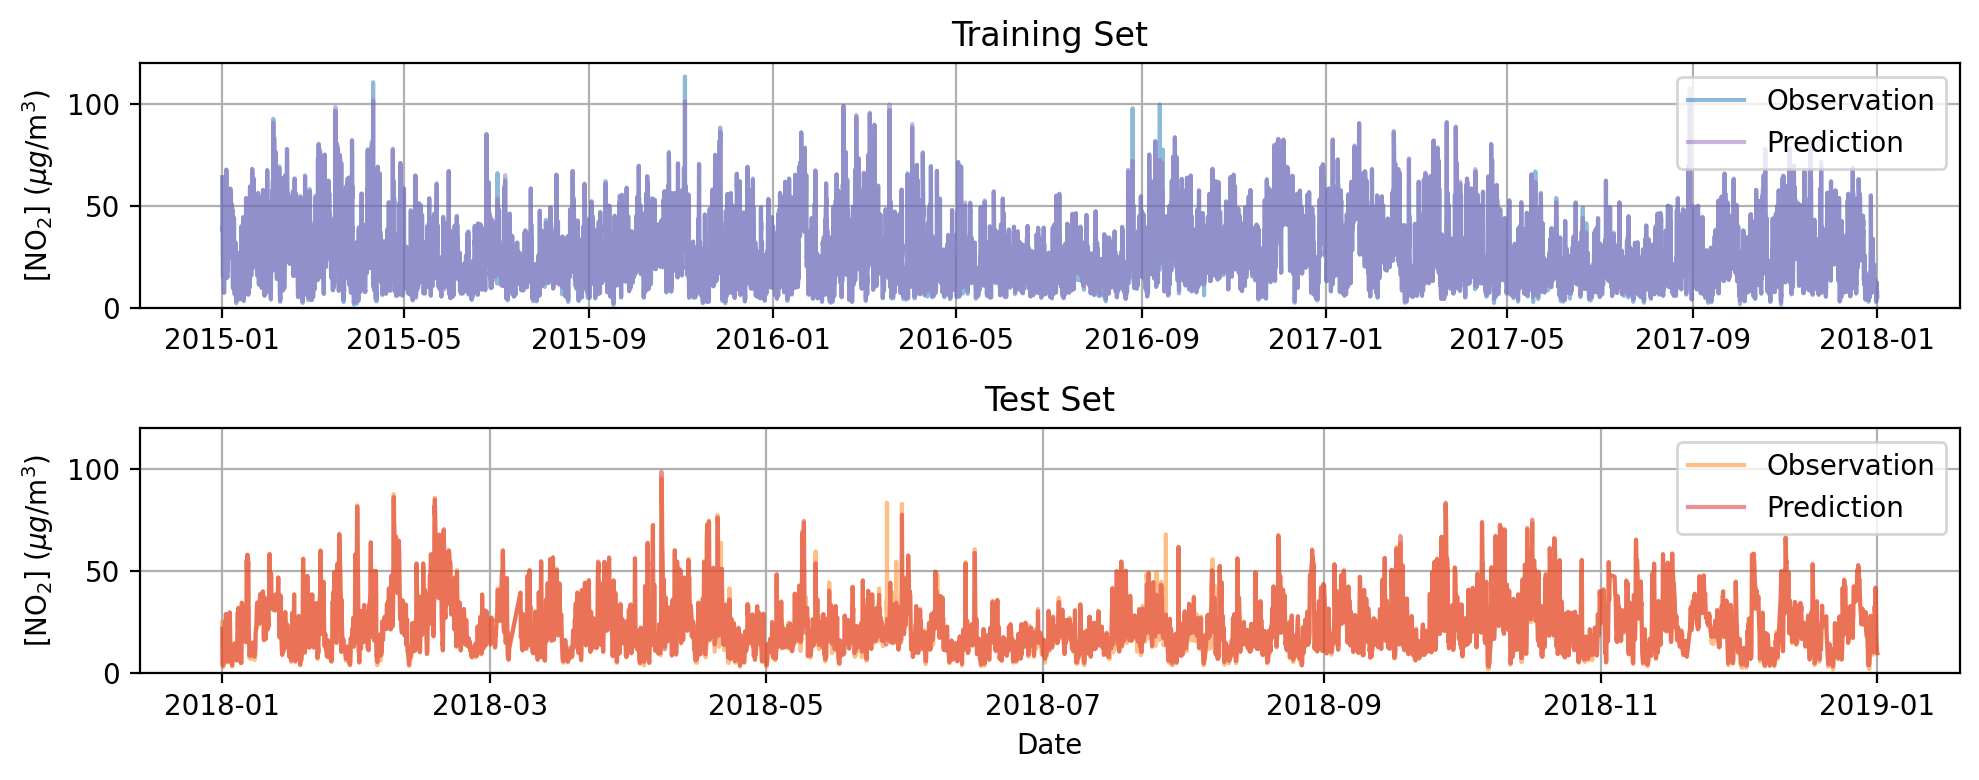

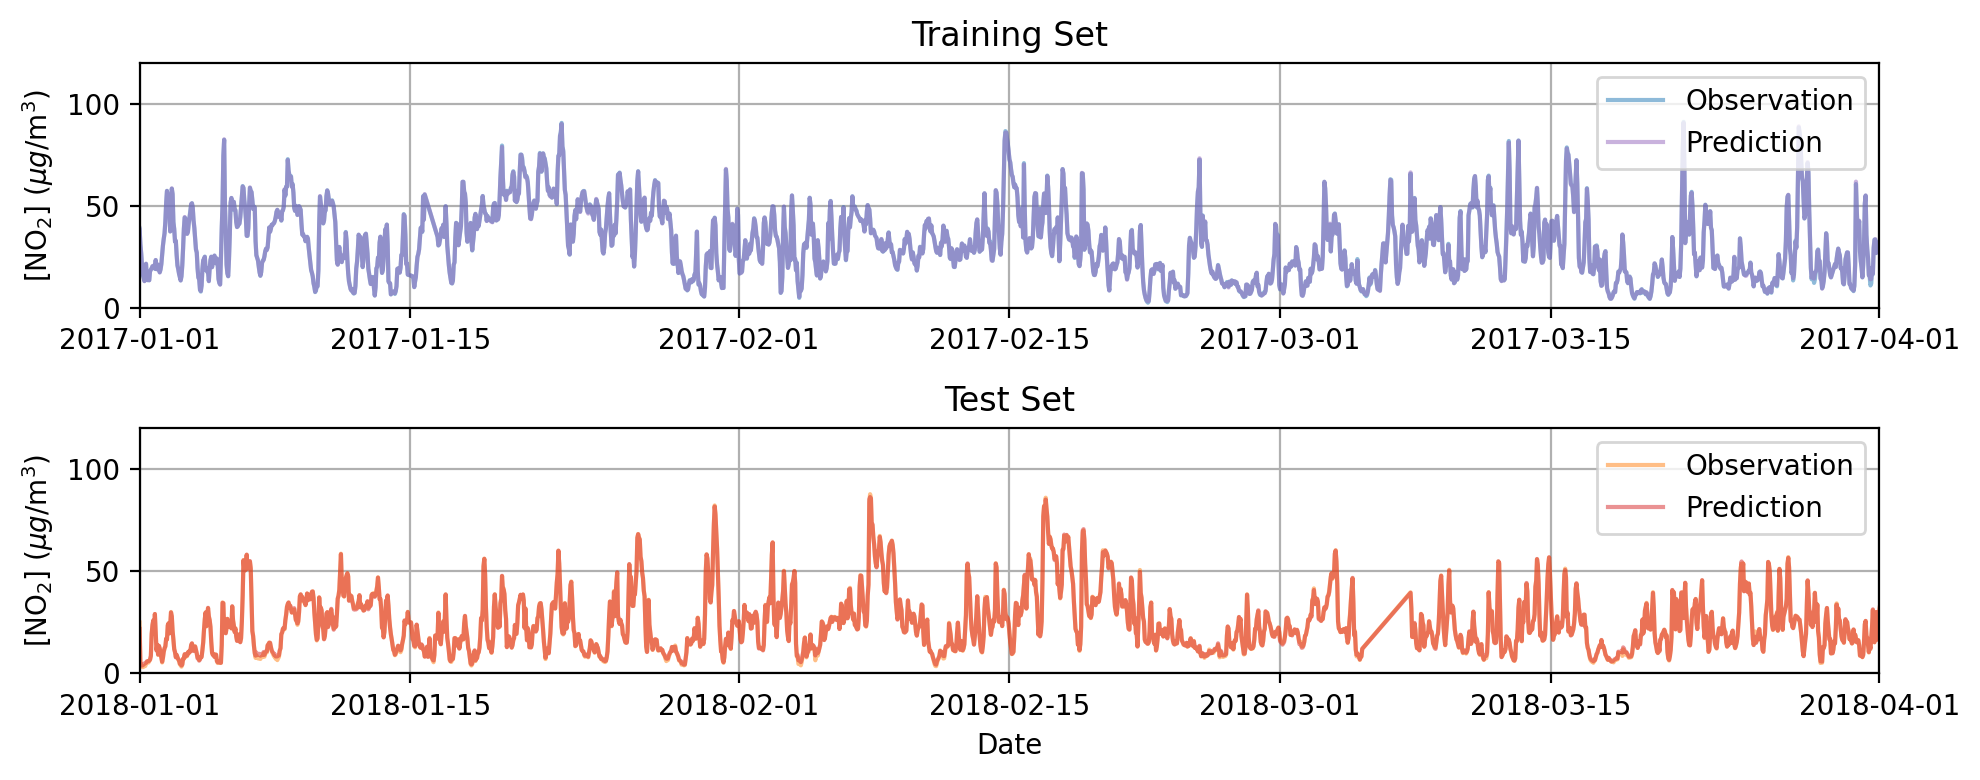

In [94]:
plot_model_pred_timeseries(t_train_3, y_train_3, y_train_pred_3, t_test_3, y_test_3, y_test_pred_3, all=True)
plot_model_pred_timeseries(t_train_3, y_train_3, y_train_pred_3, t_test_3, y_test_3, y_test_pred_3, all=False, start_month=1, n_months=3, start_day=1, n_days=0)

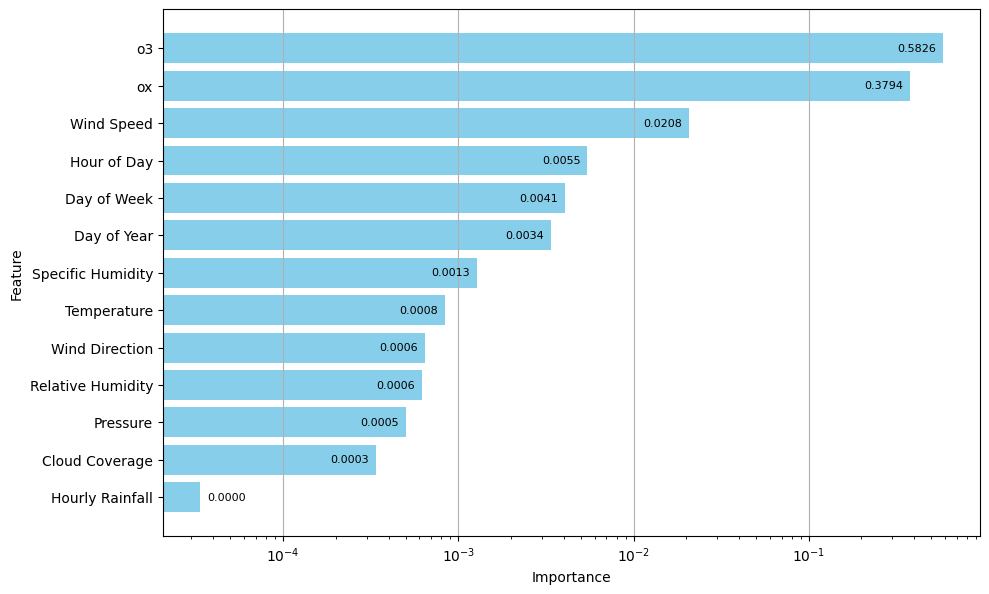

              Feature  Importance
8                  o3    0.582615
9                  ox    0.379413
1          Wind Speed    0.020807
10        Hour of Day    0.005457
12        Day of Week    0.004084
11        Day of Year    0.003373
3   Specific Humidity    0.001272
2         Temperature    0.000840
0      Wind Direction    0.000644
7   Relative Humidity    0.000620
5            Pressure    0.000504
6      Cloud Coverage    0.000337
4     Hourly Rainfall    0.000034


In [95]:
print(get_RF_feature_imp(best_rf_model_3, X_train_3, plot=True, decimals=4, relative_threshold=0.0001))

In [96]:
RF_stats_3 = get_RF_stats(y_train_3, y_test_3, y_train_pred_3, y_test_pred_3)

\begin{tabular}{lcc}
\toprule
Metric & Train & Test \\ \midrule
RMSE ($\mu g/m^3$) & 0.6960 & 1.3366 \\ 
Correlation & 0.9988 & 0.9947 \\ 
Explained Variance & 0.9977 & 0.9893 \\ 
MAE ($\mu g/m^3$) & 0.2309 & 0.4324 \\ 
\bottomrule
\end{tabular}


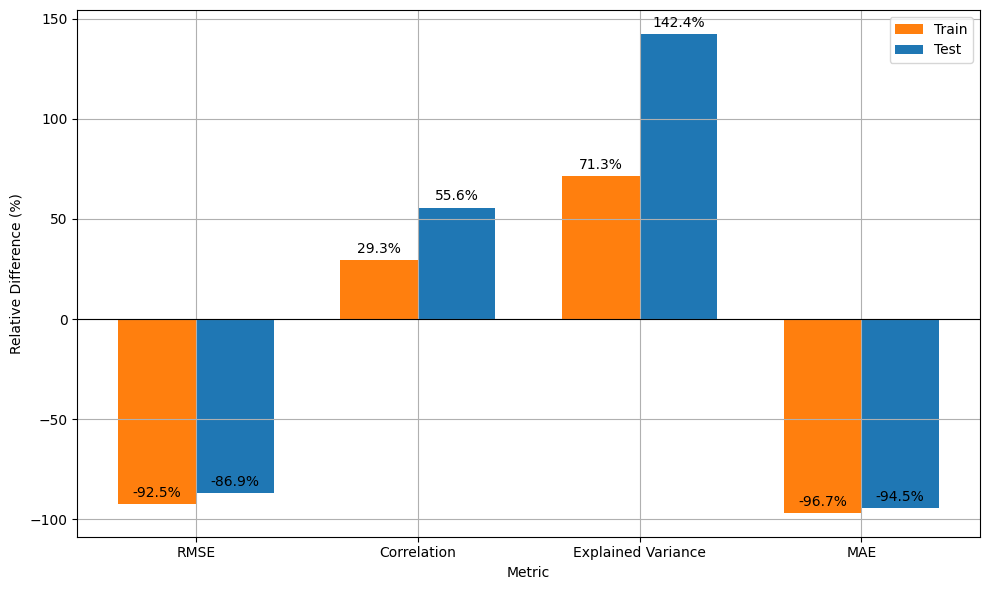

In [97]:
compare_rf_stats_relative(RF_stats_1, RF_stats_3)